In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
from scipy.special import softmax

import torch

from multiagent_ca_ppo import multiagent_ppo_dtde
from frontier_env import SmallFrontierModel

from train_multiagent_ca_ppo import batchify_observations, categorize_actions

Device set to : NVIDIA H100 PCIe


In [2]:
env_name = "SmallFrontierModel"  # environment name
max_ep_len = 2500  # max timesteps in one evaluation episode
random_seed = 123
evaluation_budget = 10000

In [3]:
# reward version specific model loading
version = 2
reward_shaping_version = f'reward_shaping_v{version}'  # reward shaping version
run_num_pretrained = 3  # version  # index of model corresponding to the reward shaping version
exogen_gen_v = 2  # exogenous generation version
directory = "MA_CA_PPO_preTrained"
directory = directory + '/' + env_name + '/'

In [4]:
# init environment
env = SmallFrontierModel(use_reward_shaping = reward_shaping_version, exogen_gen_v = exogen_gen_v)

# set seed for reproducibility
if random_seed:       
    torch.manual_seed(random_seed)
    env.seed(random_seed)  # pylint: disable=no-member
    np.random.seed(random_seed)

# init agents and load trained weights,
agent_mdp_dict = {'CDUCAB' : {'state_dim': env.observation_space['cdu-cabinet-1'].shape[0], 'action_dim': env.action_space['cdu-cabinet-1'].shape[0], 
                                    'num_centralized_actions' : 5, 'has_continuous_action_space': True},
                      
                  'CT'     : {'state_dim': env.observation_space['cooling-tower-1'].shape[0], 'action_dim': env.action_space['cooling-tower-1'].n, 
                                    'num_centralized_actions' : 1, 'has_continuous_action_space': False}
                }

ppo_agent = multiagent_ppo_dtde(agent_mdp_dict)

for agent_id in agent_mdp_dict.keys():
    checkpoint_path = directory + "PPO_{}_{}_{}_agent_{}.pth".format(env_name, random_seed, run_num_pretrained, agent_id)
    assert os.path.exists(checkpoint_path), f"Error: {checkpoint_path} does not exist"
    ppo_agent.load(checkpoint_path, agent_id)

FMU file loaded correctly: /lustre/naug/rl_ablations/LC_Frontier_5Cabinet_4_17_25.fmu
RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


In [5]:
class EvalResultsStorage:
    def __init__(self, env):
        self.obs_dict = {}
        self.act_dict = {}
        self.rl_CT_setpoint = []
        for component, variables in env.observation_vars.items():
            component_dict = dict()
            for vars in variables:
                component_dict[vars] = []
            self.obs_dict[component] = component_dict
        for component, variables in env.action_vars.items():
            component_dict = dict()
            for vars in variables:
                component_dict[vars] = []
            self.act_dict[component] = component_dict
        
    
    def store_data(self, info_dict):
        # store the observation data
        for component, variables in self.obs_dict.items():
            for idx, vars in enumerate(variables):
                self.obs_dict[component][vars].append(info_dict[component][idx])
        # store the action data
        for component, variables in self.act_dict.items():
            for idx, vars in enumerate(variables):
                if component != 'cooling-tower-1':
                    self.act_dict[component][vars].append(info_dict['actions'][component][idx])
                else:
                    self.act_dict[component][vars].append(info_dict['actions'][component])
        # store the RL CT setpoint
        self.rl_CT_setpoint.append(info_dict['actions_newsetpoint'])
        
eval_results_storage = EvalResultsStorage(env)

In [6]:
# run one evaluation over a budget
time_step = 0
episode_num = 0

# start the evaluation
while time_step < evaluation_budget:
    
    state = env.reset()
    batch_state_dict = batchify_observations(state)
    
    with tqdm.tqdm(total=max_ep_len) as pbar:
        for _ in range(max_ep_len):
            
            actions = {}  # list to store actions for each agent

            # select action for CDU setups
            action = ppo_agent.select_action(batch_state_dict['CDUCAB'], 'CDUCAB')
            actions['CDUCAB'] = action
            # select action for cooling tower
            action = ppo_agent.select_action(batch_state_dict['CT'], 'CT')
            actions['CT'] = action
            
            # categorize actions in to dict format for env
            categorized_actions = categorize_actions(actions)

            state, rewards, done, info_dict = env.step(categorized_actions)
            batch_state_dict = batchify_observations(state)
            
            # store info dictionary
            eval_results_storage.store_data(info_dict)
        
            # update time step
            time_step += 1
            
            # NB: Env never returns done=True, so we loop breaks when max_ep_len is reached

            pbar.update(1)

        episode_num += 1


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:41<00:00, 59.86it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:44<00:00, 56.23it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:40<00:00, 61.35it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:43<00:00, 57.75it/s]


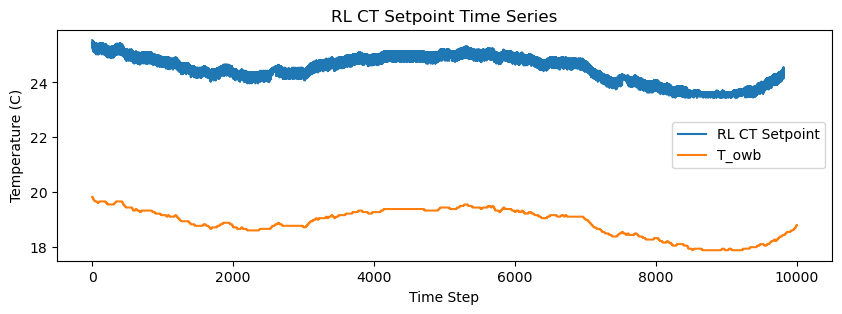

In [7]:
# set figure dimensions
plt.figure(figsize=(10, 3))

rl_CT_setpoint = np.array(eval_results_storage.rl_CT_setpoint)-273.15
T_owb = np.array(eval_results_storage.obs_dict['cooling-tower-1']['simulator_1_centralEnergyPlant_1_coolingTowerLoop_1_sources_Towb'])-273.15

# fitler outliers
mean = np.mean(rl_CT_setpoint)
std = np.std(rl_CT_setpoint)
threshold = 2 * std
filtered_rl_CT_setpoint = rl_CT_setpoint[(rl_CT_setpoint >= mean - threshold) & (rl_CT_setpoint <= mean + threshold)]

plt.plot(filtered_rl_CT_setpoint,label='RL CT Setpoint')
plt.plot(T_owb,label='T_owb')
plt.xlabel('Time Step')
plt.ylabel('Temperature (C)')
plt.legend()
plt.title('RL CT Setpoint Time Series')
plt.show()

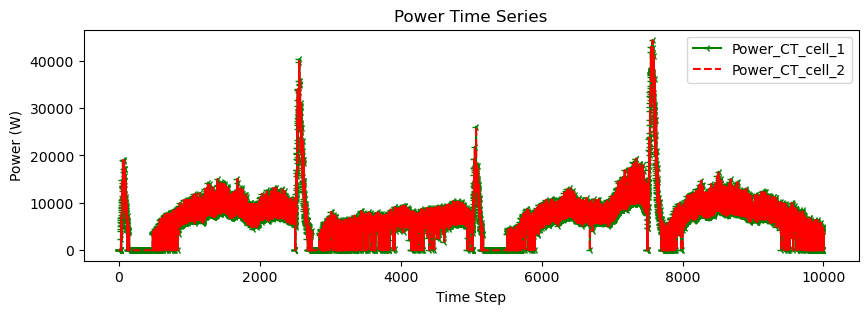

In [8]:
# set figure dimensions
plt.figure(figsize=(10, 3))

CT_cell_1 = np.array(eval_results_storage.obs_dict['cooling-tower-1']['simulator[1].centralEnergyPlant[1].coolingTowerLoop[1].coolingTower[1].cell[1].CT.PFan'])
CT_cell_2 = np.array(eval_results_storage.obs_dict['cooling-tower-1']['simulator[1].centralEnergyPlant[1].coolingTowerLoop[1].coolingTower[1].cell[2].CT.PFan'])

plt.plot(CT_cell_1, 'g3-',label='Power_CT_cell_1')
plt.plot(CT_cell_2, 'r--', label='Power_CT_cell_2')
plt.xlabel('Time Step')
plt.ylabel('Power (W)')
plt.legend()
plt.title('Power Time Series')
plt.show()

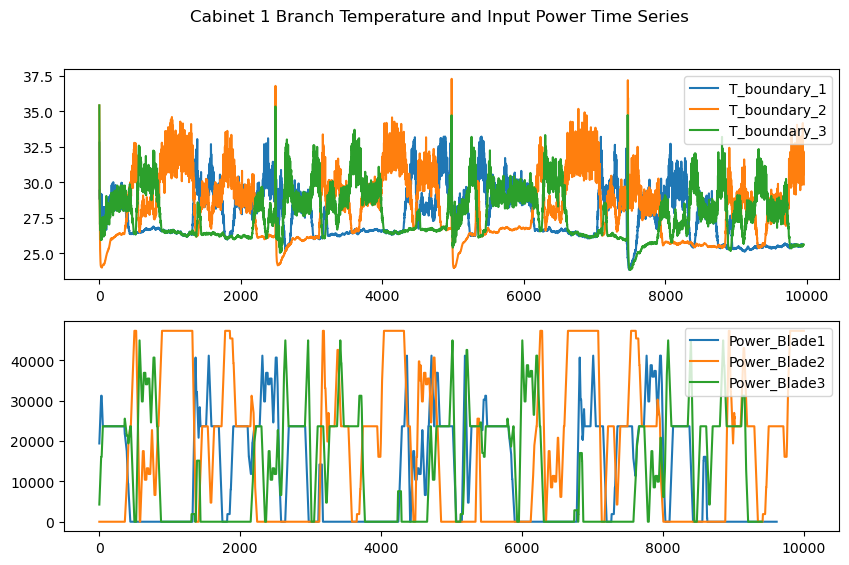

In [9]:
cabinet_num = 1

keys_to_plot = [f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_1.port.T',
                f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_2.port.T',
                f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_3.port.T',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade1',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade2',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade3']
key_names = ['T_boundary_1', 'T_boundary_2', 'T_boundary_3', 'Power_Blade1', 'Power_Blade2', 'Power_Blade3']

# plot the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Top subplot
for key,key_legend in zip(keys_to_plot[:3], key_names[:3]):
    data = np.array(eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'][key])-273.15
    
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    
    ax1.plot(filtered_data, label=key_legend)
ax1.legend()

# Bottom subplot
for key,key_legend in zip(keys_to_plot[3:], key_names[3:]):
    data = np.array(eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'][key])
    
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    
    ax2.plot(filtered_data, label=key_legend)
ax2.legend()
# add subtitle
plt.suptitle(f'Cabinet {cabinet_num} Branch Temperature and Input Power Time Series')
plt.show()

In [10]:
# store obs dict
obs_df_dict = {}
for key,val in eval_results_storage.obs_dict.items():
    obs_df_dict[key] = pd.DataFrame.from_dict(val)

# store act dict
act_df_dict = {}
for key,val in eval_results_storage.act_dict.items():
    act_df_dict[key] = pd.DataFrame.from_dict(val)
    
# store rl CT setpoint
rl_stpt_df = pd.DataFrame(eval_results_storage.rl_CT_setpoint, columns=['RL_CT_Setpoint'])

# save all three to csv
obs_df = pd.concat(obs_df_dict.values(), axis=1)
obs_df.to_csv(f'obs_df_v{version}.csv', index=False)
act_df = pd.concat(act_df_dict.values(), axis=1)
act_df.to_csv(f'act_df_v{version}.csv', index=False)
rl_stpt_df.to_csv(f'rl_stpt_df_v{version}.csv', index=False)

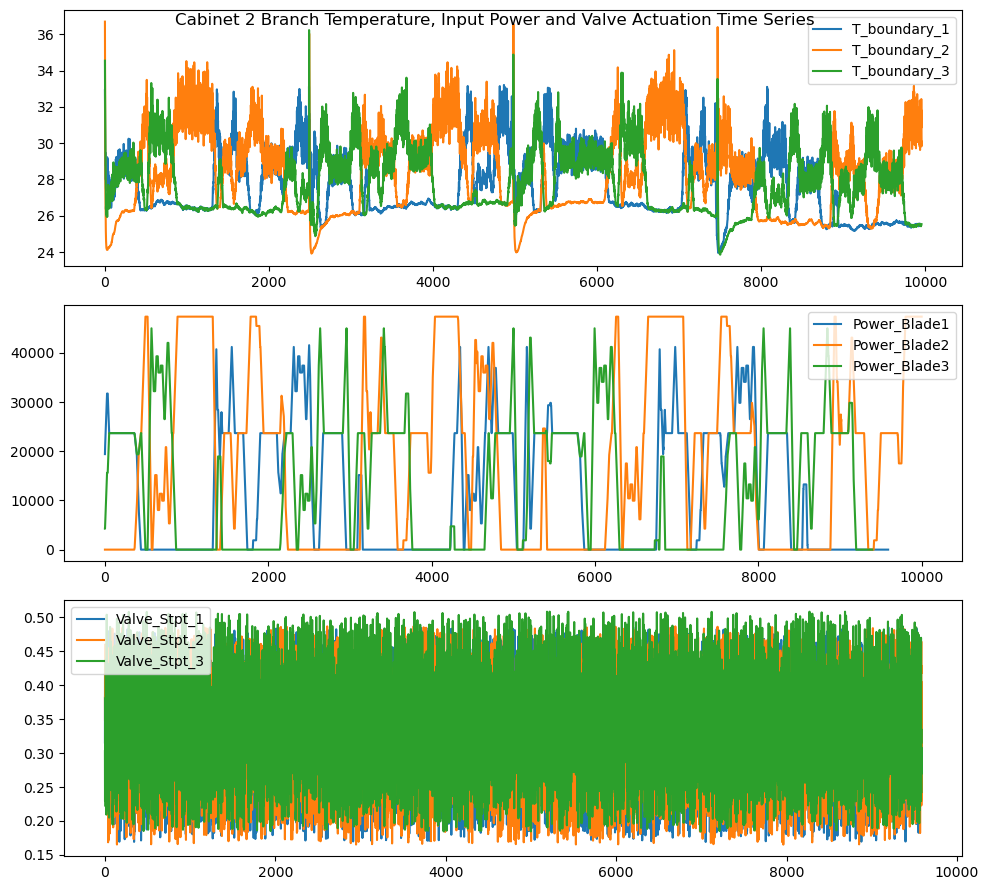

In [15]:
# study correlation between valve actuation and power input and temperature


cabinet_num = 2

keys_to_plot = [f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_1.port.T',
                f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_2.port.T',
                f'simulator[1].datacenter[1].computeBlock[{cabinet_num}].cabinet[1].boundary_3.port.T',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade1',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade2',
                f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_ComputePowerBlade3']
key_names = ['T_boundary_1', 'T_boundary_2', 'T_boundary_3', 'Power_Blade1', 'Power_Blade2', 'Power_Blade3']

# plot the data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 9))

# Top subplot
for key,key_legend in zip(keys_to_plot[:3], key_names[:3]):
    data = np.array(eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'][key])-273.15
    
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    
    ax1.plot(filtered_data, label=key_legend)
ax1.legend()

# Medium subplot
for key,key_legend in zip(keys_to_plot[3:], key_names[3:]):
    data = np.array(eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'][key])
    
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    ax2.plot(filtered_data, label=key_legend)
ax2.legend()

# Bottom subplot
values_to_plot = [f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_Valve_Stpts[1]',
  f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_Valve_Stpts[2]',
  f'simulator_1_datacenter_1_computeBlock_{cabinet_num}_cabinet_1_sources_Valve_Stpts[3]']
val_names = ['Valve_Stpt_1', 'Valve_Stpt_2', 'Valve_Stpt_3']
for key,key_legend in zip(values_to_plot, val_names):
    data = np.array(eval_results_storage.act_dict[f'cdu-cabinet-{cabinet_num}'][key])
    
    # fitler outliers
    mean = np.mean(data)
    std = np.std(data)
    threshold = 2 * std
    filtered_data = data[(data >= mean - threshold) & (data <= mean + threshold)]
    ax3.plot(filtered_data, label=key_legend)
ax3.legend()
plt.tight_layout()
# add subtitle
plt.suptitle(f'Cabinet {cabinet_num} Branch Temperature, Input Power and Valve Actuation Time Series')
plt.show()